In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [132]:
from pathlib import Path
import math
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
class NullClass:
    def do_nothing(*args, **kwargs):
        pass
    def add_colorbar(self, im, **kwargs):
        return plt.colorbar(im)
    def __getattr__(self, _):
        return self.do_nothing
try:
    from mpl_utils import MPLAdjutant
    adj = MPLAdjutant()
    adj.set_defaults()
except ImportError:
    adj = NullClass()

In [4]:
import gpytorch
import botorch

In [5]:
from easyBO import gp, bo

# Very simple example from the BoTorch docs using `easyBO`

See [here](https://botorch.org/v/0.1.0/tutorials/fit_model_with_torch_optimizer). In this simple example, we do the following:
1. Initialize a single task GP regressor from dummy training data
2. Assume homoscedastic noise
3. Train the GP hyperparameters
4. Plot the results

In [6]:
np.random.seed(123)
torch.manual_seed(123)

# use regular spaced points on the interval [0, 1]
train_x = torch.linspace(0, 1, 15)

# training data needs to be explicitly multi-dimensional
train_x = train_x.unsqueeze(1)

# sample observed values and add some synthetic noise
train_y = torch.sin(train_x * (2 * math.pi)) + 0.15 * torch.randn_like(train_x)

# Testing grid
grid = torch.linspace(0, 1, 101)

Get the initial model conditioned on the training data, and run inference on the un-optimized GP, just to see what it looks like.

In [7]:
model = gp.get_single_task_gp_regressor(train_x=train_x, train_y=train_y)
pre_fitting_infer = gp.infer(model=model, grid=grid)

/Users/mc/miniforge3/envs/py3.9/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [8]:
for param in model.named_parameters():
    print(param)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))


Now, optimize the hyper-parameters (by default, this is just a kernel of the form `Const x RBF`.

In [9]:
losses = gp.train_gp_hyperparameters(model=model, train_x=train_x, train_y=train_y)

0/100
	 Loss        = 1.064
	 Lengthscale = 0.693
	 Noise       = 0.693
20/100
	 Loss        = 0.446
	 Lengthscale = 0.160
	 Noise       = 0.121
40/100
	 Loss        = -0.091
	 Lengthscale = 0.243
	 Noise       = 0.016
60/100
	 Loss        = -0.204
	 Lengthscale = 0.282
	 Noise       = 0.005
80/100
	 Loss        = -0.211
	 Lengthscale = 0.287
	 Noise       = 0.006
100/100
	 Loss        = -0.211
	 Lengthscale = 0.282
	 Noise       = 0.006


In [10]:
for param in model.named_parameters():
    print(param)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-5.1699], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([-0.0302], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(0.4992, requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-1.1200]], requires_grad=True))


Run inference again on the trained model.

In [11]:
post_fitting_infer = gp.infer(model=model, grid=grid)

Plot them both.

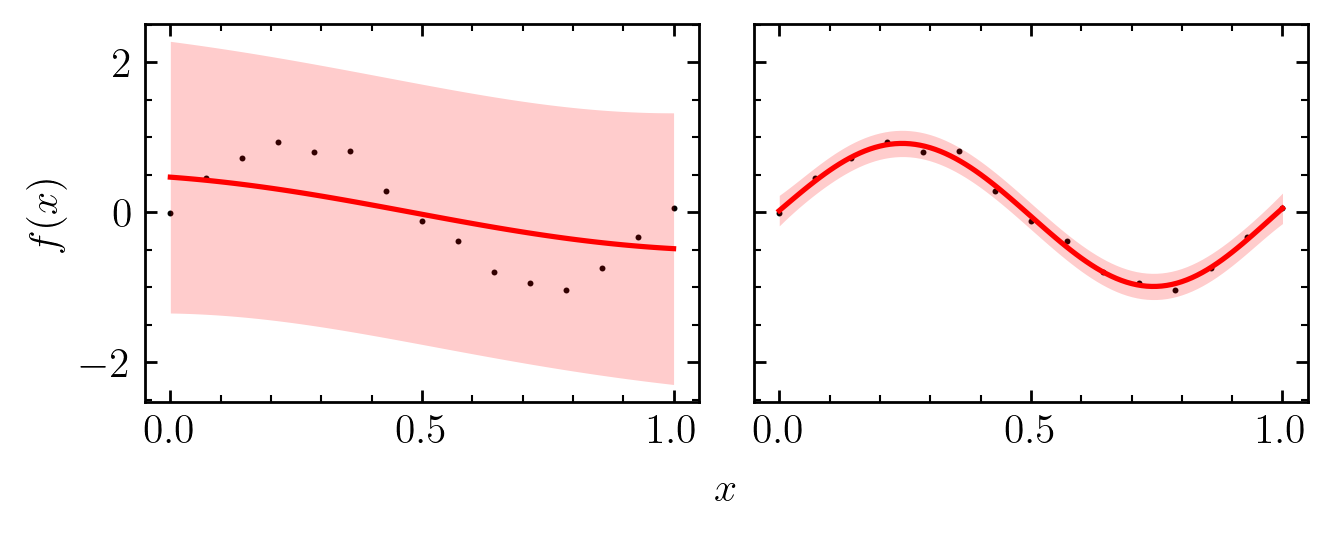

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2), sharey=True, sharex=True)

ax = axs[0]
adj.set_grids(ax, grid=False)
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, pre_fitting_infer["mean"], "r-")
ax.fill_between(grid.squeeze(), pre_fitting_infer['mean-2sigma'], pre_fitting_infer['mean+2sigma'], alpha=0.2, color="red", linewidth=0)

ax = axs[1]
adj.set_grids(ax, grid=False)
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, post_fitting_infer["mean"], "r-")
ax.fill_between(grid.squeeze(), post_fitting_infer['mean-2sigma'], post_fitting_infer['mean+2sigma'], alpha=0.2, color="red", linewidth=0)

axs[0].set_ylabel(r"$f(x)$")

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$x$", labelpad=20)

plt.subplots_adjust(wspace=0.1)
plt.show()

# Another example (this one is custom)

Another very simple example, but this one uses a custom function which is a bit trickier than the one above. That said, the procedure we take is identical.

In [13]:
np.random.seed(123)
torch.manual_seed(123)

x1 = np.linspace(0, 0.5, 10)
x3 = np.linspace(0.75, 1, 10)

train_x = torch.FloatTensor(np.concatenate([x1, x3])).reshape(-1, 1)
train_y = 5*train_x**2 + np.sin(train_x * 40) / 3 + torch.FloatTensor(np.random.normal(scale=0.1, size=train_x.shape))
train_y = train_y

grid = np.linspace(-2, 3, 1000).reshape(-1, 1)

In [14]:
model = gp.get_single_task_gp_regressor(train_x=train_x, train_y=train_y)
pre_fitting_infer = gp.infer(model=model, grid=grid)

In [15]:
losses = gp.train_gp_hyperparameters(model=model, train_x=train_x, train_y=train_y)
post_fitting_infer = gp.infer(model=model, grid=grid)

0/100
	 Loss        = 1.774
	 Lengthscale = 0.693
	 Noise       = 0.693
20/100
	 Loss        = 0.755
	 Lengthscale = 0.248
	 Noise       = 0.122
40/100
	 Loss        = 0.645
	 Lengthscale = 0.385
	 Noise       = 0.056
60/100
	 Loss        = 0.618
	 Lengthscale = 0.390
	 Noise       = 0.071
80/100
	 Loss        = 0.607
	 Lengthscale = 0.403
	 Noise       = 0.065
100/100
	 Loss        = 0.600
	 Lengthscale = 0.430
	 Noise       = 0.066


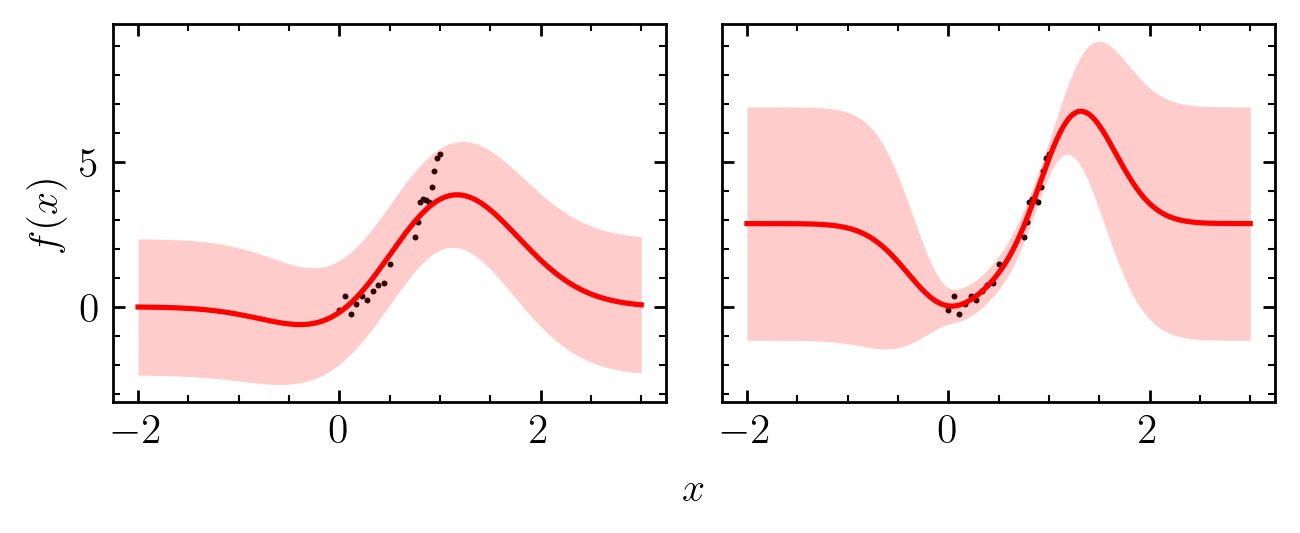

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2), sharey=True, sharex=True)

ax = axs[0]
adj.set_grids(ax, grid=False)
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, pre_fitting_infer["mean"], "r-")
ax.fill_between(grid.squeeze(), pre_fitting_infer['mean-2sigma'], pre_fitting_infer['mean+2sigma'], alpha=0.2, color="red", linewidth=0)

ax = axs[1]
adj.set_grids(ax, grid=False)
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, post_fitting_infer["mean"], "r-")
ax.fill_between(grid.squeeze(), post_fitting_infer['mean-2sigma'], post_fitting_infer['mean+2sigma'], alpha=0.2, color="red", linewidth=0)

axs[0].set_ylabel(r"$f(x)$")

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$x$", labelpad=20)

plt.subplots_adjust(wspace=0.1)
plt.show()

# Bayesian optimization example

Follow along [here](https://botorch.org/tutorials/compare_mc_analytic_acquisition). This is a simple boilerplate example using a tutorial. We won't be visualizing/testing anything specific.

In [17]:
from botorch.test_functions import Hartmann
neg_hartmann6 = Hartmann(dim=6, negate=True)

In [18]:
train_x = torch.rand(10, 6)
train_y = neg_hartmann6(train_x).unsqueeze(-1)

In [19]:
model = gp.get_single_task_gp_regressor(train_x=train_x, train_y=train_y)

In [20]:
loss = gp.train_gp_hyperparameters(model=model, train_x=train_x, train_y=train_y, training_iter=1000)

0/1000
	 Loss        = 1.074
	 Lengthscale = 0.693
	 Noise       = 0.693
200/1000
	 Loss        = 0.368
	 Lengthscale = 0.326
	 Noise       = 0.120
400/1000
	 Loss        = 0.368
	 Lengthscale = 0.307
	 Noise       = 0.120
600/1000
	 Loss        = 0.368
	 Lengthscale = 0.305
	 Noise       = 0.118
800/1000
	 Loss        = 0.366
	 Lengthscale = 0.285
	 Noise       = 0.104
1000/1000
	 Loss        = 0.362
	 Lengthscale = 0.224
	 Noise       = 0.035


We'll use the `ExpectedImprovement` acquisition function for now. This requires `best_value`. To start, we'll use the standard analytic `EI`, which is implemented for us in `bo.ask`.

In [21]:
best_value = train_y.max()

In [22]:
torch.manual_seed(0) # to keep the restart conditions the same
asked_new_point = bo.ask(
    model=model,
    bounds=[(0, 1) for _ in range(6)],
    acquisition_function="EI",
    acquisition_function_kwargs={"best_f": best_value},
    optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100}
)

In [23]:
asked_new_point

tensor([[0.0330, 0.1210, 0.3212, 0.3638, 0.1414, 0.8109]])

We can then use a Monte Carlo sampler implemented in `botorch`. These can seamlessly be passed to the `bo.ask` function.

In [24]:
from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

In [25]:
sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
torch.manual_seed(seed=0) # to keep the restart conditions the same

In [26]:
asked_mc_point = bo.ask(
    model=model,
    bounds=[(0, 1) for _ in range(6)],
    acquisition_function=qExpectedImprovement,
    acquisition_function_kwargs={"best_f": best_value, "sampler": sampler},
    optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100}
)

In [27]:
asked_mc_point

tensor([[0.0331, 0.1212, 0.3210, 0.3639, 0.1410, 0.8112]])

Note that for the same random states the analytic and Monte Carlo results are in perfect agreement (and generally, they are always in _almost_ perfect agreement). Finally, we demonstrate the joint optimization of the acquisition function, the true power of `botorch`, where we can actually draw multiple samples at a time.

In [28]:
sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
torch.manual_seed(seed=0) # to keep the restart conditions the same

In [29]:
asked_mc_point = bo.ask(
    model=model,
    bounds=[(0, 1) for _ in range(6)],
    acquisition_function=qExpectedImprovement,
    acquisition_function_kwargs={"best_f": best_value, "sampler": sampler},
    optimize_acqf_kwargs={"q": 2, "num_restarts": 20, "raw_samples": 512}
)

In [30]:
asked_mc_point

tensor([[0.1089, 0.1209, 0.3113, 0.3769, 0.0581, 0.7739],
        [0.0027, 0.1945, 0.3277, 0.3824, 0.1927, 0.8622]])

These sampled points are those which will _jointly_ optimize the acquisition function. In other words, we can "ask" for multiple points at a time!

# A practical active learning example

Often we just want to "plug-and-play" with active learning to make e.g. experiments more efficient. It doesn't seem that `botorch` has simple active learning implementations, so we wrote our own. These are small modifications of the `UpperConfidenceBound` classes, where we basically set `beta -> infinity`.

In [31]:
np.random.seed(123)
x1 = np.linspace(0, 0.2, 20)
x4 = np.linspace(1.4, 1.6, 20)
train_x = torch.FloatTensor(np.concatenate([x1, x4])).reshape(-1, 1)
train_y = 5*train_x**2 + np.sin(train_x * 50) / 3 + torch.FloatTensor(np.random.normal(scale=0.1, size=train_x.shape))
train_y = train_y
grid = np.linspace(-2, 3, 1000).reshape(-1, 1)

In [32]:
model = gp.get_single_task_gp_regressor(train_x=train_x, train_y=train_y)
pred = gp.infer(model=model, grid=grid)

For consistency with the other examples, here's the un-optimized GP conditioned on the training data.

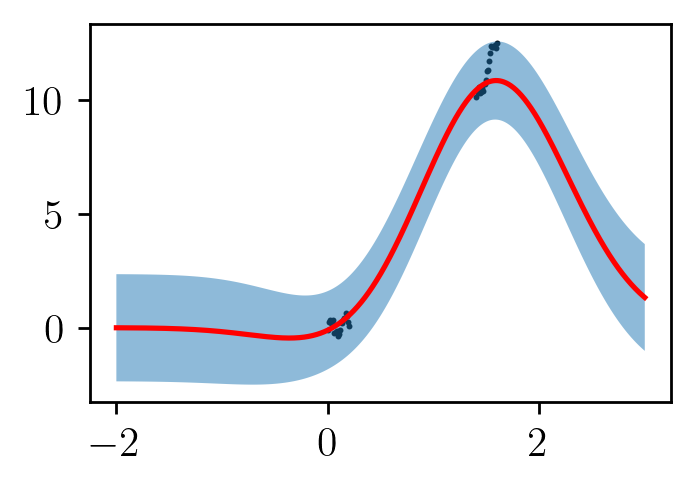

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)

plt.show()

In [34]:
losses = gp.train_gp_hyperparameters(model=model, train_x=train_x, train_y=train_y, training_iter=1000)

0/1000
	 Loss        = 3.297
	 Lengthscale = 0.693
	 Noise       = 0.693
200/1000
	 Loss        = 0.554
	 Lengthscale = 0.270
	 Noise       = 0.069
400/1000
	 Loss        = 0.514
	 Lengthscale = 0.284
	 Noise       = 0.069
600/1000
	 Loss        = 0.496
	 Lengthscale = 0.295
	 Noise       = 0.068
800/1000
	 Loss        = 0.486
	 Lengthscale = 0.305
	 Noise       = 0.068
1000/1000
	 Loss        = 0.480
	 Lengthscale = 0.314
	 Noise       = 0.069


In [35]:
pred = gp.infer(model=model, grid=grid)

## Ask

After optimization, we can play around with the `MaxVar` and `qMaxVar`policies. Lets start with the simpler analytic `MaxVar` policy.

In [36]:
bounds = [(-0.2, 1.5)]
pt = bo.ask(
    model=model,
    bounds=bounds,
    acquisition_function="MaxVar",
    acquisition_function_kwargs=dict(),
    optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 512}
)

In [37]:
observed_pred = pred["observed_pred"]

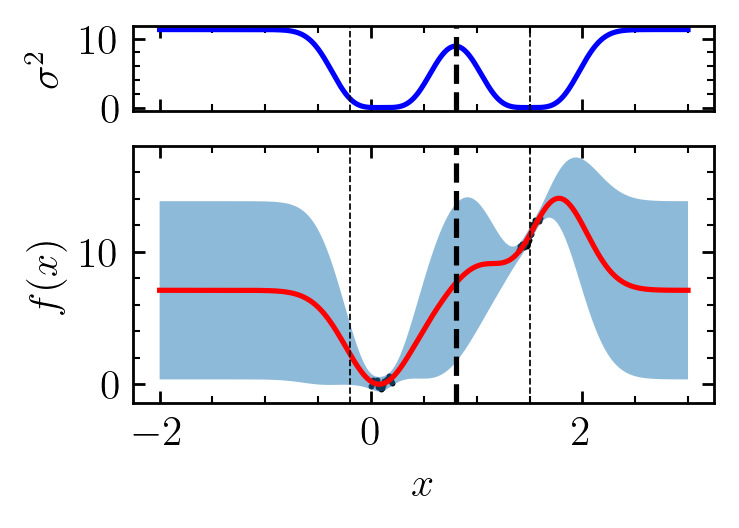

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(3, 2), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

ax = axs[0]
ax.plot(grid, observed_pred.variance.detach().numpy(), color="blue")
ax.axvline(pt.item(), linestyle="--", color="black")
ax.axvline(bounds[0][0], linestyle="--", linewidth=0.5, color="black")
ax.axvline(bounds[0][1], linestyle="--", linewidth=0.5, color="black")
adj.set_grids(ax, grid=False)
ax.set_ylabel(r"$\sigma^2$")

ax = axs[1]
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)
ax.axvline(pt.item(), linestyle="--", color="black")
ax.axvline(bounds[0][0], linestyle="--", linewidth=0.5, color="black")
ax.axvline(bounds[0][1], linestyle="--", linewidth=0.5, color="black")
adj.set_grids(ax, grid=False)
ax.set_ylabel(r"$f(x)$")
ax.set_xlabel(r"$x$")

plt.show()

Now however, we can _jointly_ optimize the variance. Say that we can run 2 experiments in parallel. It might not be the case that the point chosen when just doing a sequential experiment is the same as one of the two points that are jointly optimizing.

In [39]:
pts = bo.ask(
    model=model,
    bounds=[(-0.2, 1.5)],
    acquisition_function="qMaxVar",  # note the qMaxVar
    acquisition_function_kwargs=dict(),
    optimize_acqf_kwargs={"q": 2, "num_restarts": 20, "raw_samples": 512}  # Note q==2
)

In [40]:
pts

tensor([[0.6788],
        [0.9205]])

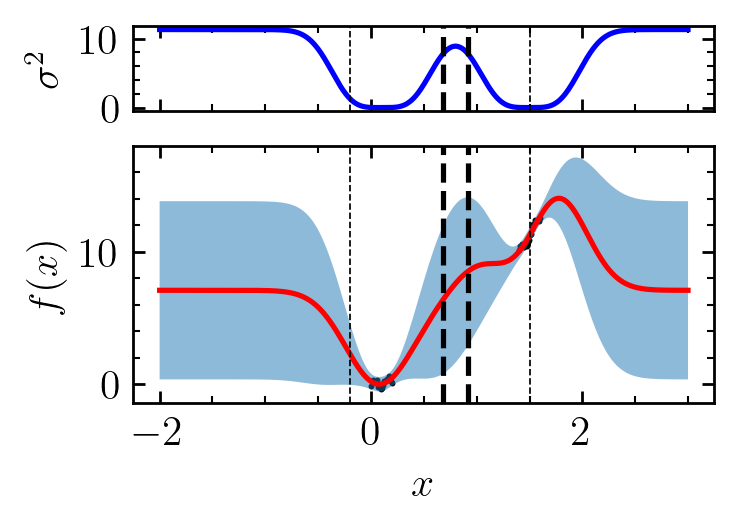

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(3, 2), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

ax = axs[0]
ax.plot(grid, observed_pred.variance.detach().numpy(), color="blue")
for pt in pts:
    ax.axvline(pt.item(), linestyle="--", color="black")
ax.axvline(bounds[0][0], linestyle="--", linewidth=0.5, color="black")
ax.axvline(bounds[0][1], linestyle="--", linewidth=0.5, color="black")
adj.set_grids(ax, grid=False)
ax.set_ylabel(r"$\sigma^2$")

ax = axs[1]
ax.scatter(train_x.numpy(), train_y.numpy(), color="black", s=0.5)
ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)
for pt in pts:
    ax.axvline(pt.item(), linestyle="--", color="black")
ax.axvline(bounds[0][0], linestyle="--", linewidth=0.5, color="black")
ax.axvline(bounds[0][1], linestyle="--", linewidth=0.5, color="black")
adj.set_grids(ax, grid=False)
ax.set_ylabel(r"$f(x)$")
ax.set_xlabel(r"$x$")

plt.show()

Indeed, these are not the same points.

## Tell

In [42]:
new_x = torch.tensor(np.array([-1.5, -1.0]).reshape(-1, 1)).float()
new_y = torch.tensor(np.array([5.0, 4.0])).float()

In [43]:
new_model = gp.tell(model=model, new_x=new_x, new_y=new_y)

In [44]:
new_x, new_y = gp.get_training_data(model=model)

In [45]:
pred = gp.infer(model=new_model, grid=grid)

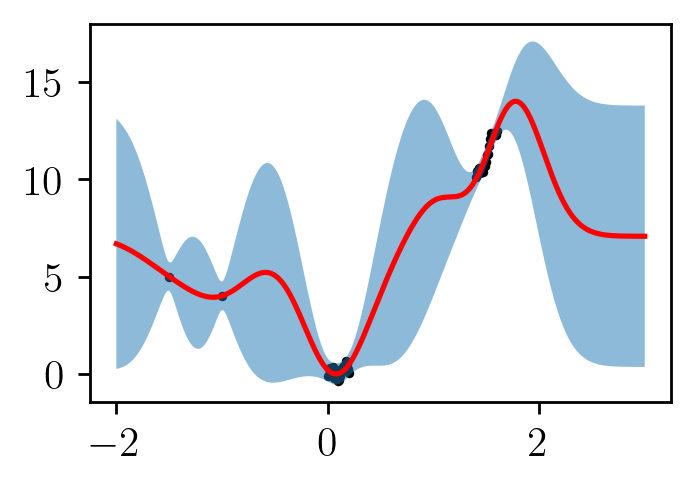

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.scatter(new_model.train_inputs[0].detach().numpy(), new_model.train_targets.detach().numpy(), color="black", s=3)
ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)

plt.show()

Using the new model (and note, we've told it about the new data), we can then refine the hyperparameters further.

In [47]:
with gpytorch.settings.debug(False):
    losses = gp.train_gp_hyperparameters(model=new_model, train_x=new_x, train_y=new_y, training_iter=1000)

0/1000
	 Loss        = 0.480
	 Lengthscale = 0.314
	 Noise       = 0.069
200/1000
	 Loss        = 0.460
	 Lengthscale = 0.400
	 Noise       = 0.070
400/1000
	 Loss        = 0.459
	 Lengthscale = 0.426
	 Noise       = 0.070
600/1000
	 Loss        = 0.458
	 Lengthscale = 0.437
	 Noise       = 0.070
800/1000
	 Loss        = 0.458
	 Lengthscale = 0.441
	 Noise       = 0.070
1000/1000
	 Loss        = 0.458
	 Lengthscale = 0.443
	 Noise       = 0.070


In [48]:
pred = gp.infer(model=new_model, grid=grid)

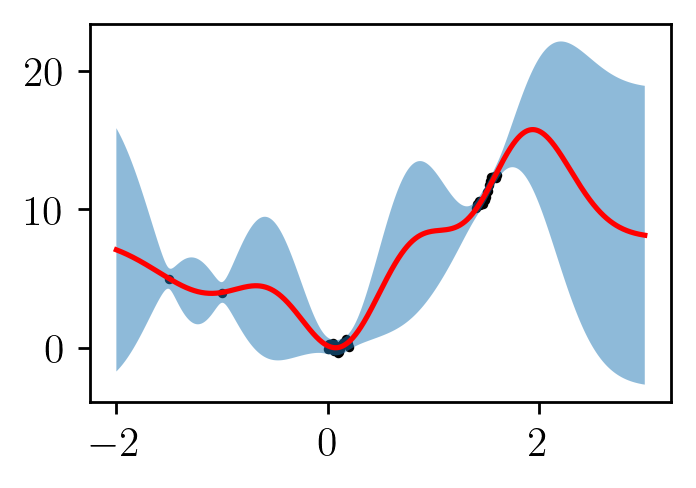

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.scatter(new_model.train_inputs[0].detach().numpy(), new_model.train_targets.detach().numpy(), color="black", s=3)
ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)

plt.show()

We often want to then improve the model with the next-sampled point. We can do this in two flavors.
- Recondition the GP, but don't revise the hyperparameters
- Recondition the GP, but do re-train the hyperparamters

# A toy experiment

Let's now consider the holy grail: we want to run an experiment according to some policy (e.g. to find the best interpolating function which is very certain everywhere, or to maximize some quantity). Let's do this on a toy source of truth that is easy to visualize. We'll use the same function as before:

In [60]:
def truth(x):
    if isinstance(x, (float, int)):
        x = torch.tensor(x, dtype=torch.float)
    return 5*x**2 + torch.sin(x * 50) / 3 + torch.FloatTensor(np.random.normal(scale=0.2, size=x.shape))

In [61]:
np.random.seed(123)

x1 = np.linspace(0, 0.2, 2)
x4 = np.linspace(1.4, 1.6, 2)
train_x = torch.FloatTensor(np.concatenate([x1, x4])).reshape(-1, 1)
train_y = truth(train_x)
grid = np.linspace(-2, 3, 1000).reshape(-1, 1)

We begin by initializing a model on minimal training data, as usual, and then training it.

In [62]:
model = gp.get_single_task_gp_regressor(train_x=train_x, train_y=train_y)
_ = gp.train_gp_hyperparameters(model=model, train_x=train_x, train_y=train_y, training_iter=1000)
pred = gp.infer(model=model, grid=grid)

0/1000
	 Loss        = 16.624
	 Lengthscale = 0.693
	 Noise       = 0.693
200/1000
	 Loss        = 3.154
	 Lengthscale = 0.479
	 Noise       = 4.110
400/1000
	 Loss        = 2.977
	 Lengthscale = 0.493
	 Noise       = 4.428
600/1000
	 Loss        = 2.880
	 Lengthscale = 0.512
	 Noise       = 3.834
800/1000
	 Loss        = 2.766
	 Lengthscale = 0.555
	 Noise       = 2.150
1000/1000
	 Loss        = 2.595
	 Lengthscale = 0.723
	 Noise       = 0.346


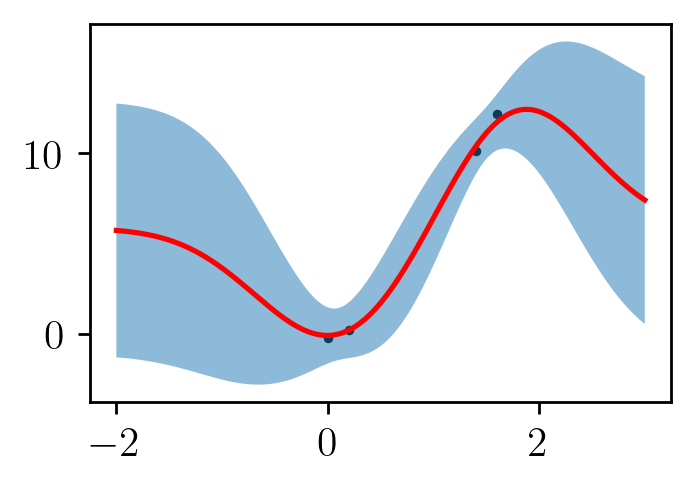

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.scatter(train_x.detach().numpy(), train_y.detach().numpy(), color="black", s=3)
ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)

plt.show()

Consider that we wish to do simple active learning. In that case, we want to create a loop, where the at each instance of the loop we "ask" for a new point, query the source of `truth`, and add that data back to the training set.

In [64]:
torch.manual_seed(123)

NLOOP = 10

for ii in range(NLOOP):
    candidate = bo.ask(
        model=model,
        bounds=[(-2, 3)],
        acquisition_function="MaxVar",
        optimize_acqf_kwargs={
            "q": 1,
            "num_restarts": 5,
            "raw_samples": 20,
        }
    )
    model = gp.tell(model=model, new_x=candidate, new_y=truth(candidate))

In [65]:
new_x, new_y = gp.get_training_data(model=model)

In [66]:
pred = gp.infer(model=model, grid=grid)

In [67]:
loss = gp.train_gp_hyperparameters(model=model, train_x=new_x, train_y=new_y, training_iter=1000)

0/1000
	 Loss        = 7.406
	 Lengthscale = 0.723
	 Noise       = 0.344
200/1000
	 Loss        = 3.998
	 Lengthscale = 0.781
	 Noise       = 4.895
400/1000
	 Loss        = 3.379
	 Lengthscale = 0.877
	 Noise       = 0.258
600/1000
	 Loss        = 3.084
	 Lengthscale = 0.966
	 Noise       = 0.190
800/1000
	 Loss        = 2.908
	 Lengthscale = 1.019
	 Noise       = 0.162
1000/1000
	 Loss        = 2.785
	 Lengthscale = 1.059
	 Noise       = 0.146


In [68]:
pred = gp.infer(model=model, grid=grid)

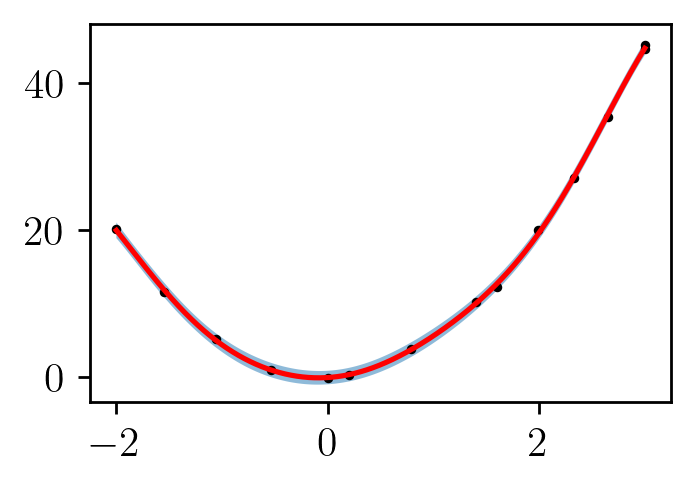

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))


ax.plot(grid, pred["mean"], "r-")
ax.fill_between(grid.squeeze(), pred['mean-2sigma'], pred['mean+2sigma'], alpha=0.5)
ax.scatter(new_x, new_y, color="black", s=3)

plt.show()

# 2d input data

In [125]:
def grids_to_coordinates(grids):
    x = np.meshgrid(*grids)
    return np.array([xx.flatten() for xx in x]).T

In [126]:
np.random.seed(127)
N = 100
M = 150
idx = np.random.choice([xx for xx in range(N*M)], 20, replace=False)
idx.sort()

grid_x = np.linspace(-4, 5, N)
grid_y = np.linspace(-5, 4, M)

# Feature data
g1, g2 = np.meshgrid(grid_x, grid_y)
X = np.array([g1.flatten(), g2.flatten()]).T
X = X[idx, :]

X_original = X.copy()

# alpha = (np.linspace(-2, 2, N**2)[idx])**2 * 0  # Noise/uncertainty
alpha = np.array([1e-5 for _ in range(len(X))])

def func(x, y):
    return (1 - x / 3. + x ** 5 + y ** 5) * np.exp(-x ** 2 - y ** 2) + np.exp(-(x - 2)**2 - (y + 4)**2)

def truth(X):
    x = X[:, 0]
    y = X[:, 1]
    return func(x, y)

def truth_meshgrid(x, y):
    x = x.reshape(-1, 1)
    y = y.reshape(1, -1)
    return func(x, y)
    

y = truth(X)  # Target data
y = y.reshape(-1, 1)
train_x = X
train_y = y

In [127]:
grid = grids_to_coordinates([grid_x, grid_y])
z = truth_meshgrid(grid_x, grid_y)
z_min = -np.abs(z).max()
z_max = np.abs(z).max()

In [128]:
model = gp.get_single_task_gp_regressor(train_x=train_x, train_y=train_y)
_ = gp.train_gp_hyperparameters(model=model, train_x=train_x, train_y=train_y, training_iter=1000)

0/1000
	 Loss        = 1.112
	 Lengthscale = 0.693
	 Noise       = 0.693
200/1000
	 Loss        = 0.120
	 Lengthscale = 0.974
	 Noise       = 0.003
400/1000
	 Loss        = 0.116
	 Lengthscale = 0.968
	 Noise       = 0.001
600/1000
	 Loss        = 0.115
	 Lengthscale = 0.967
	 Noise       = 0.001
800/1000
	 Loss        = 0.115
	 Lengthscale = 0.966
	 Noise       = 0.000
1000/1000
	 Loss        = 0.115
	 Lengthscale = 0.966
	 Noise       = 0.000


In [129]:
pred = gp.infer(model=model, grid=grid)

In [130]:
mu = pred["mean"].reshape(M, N)

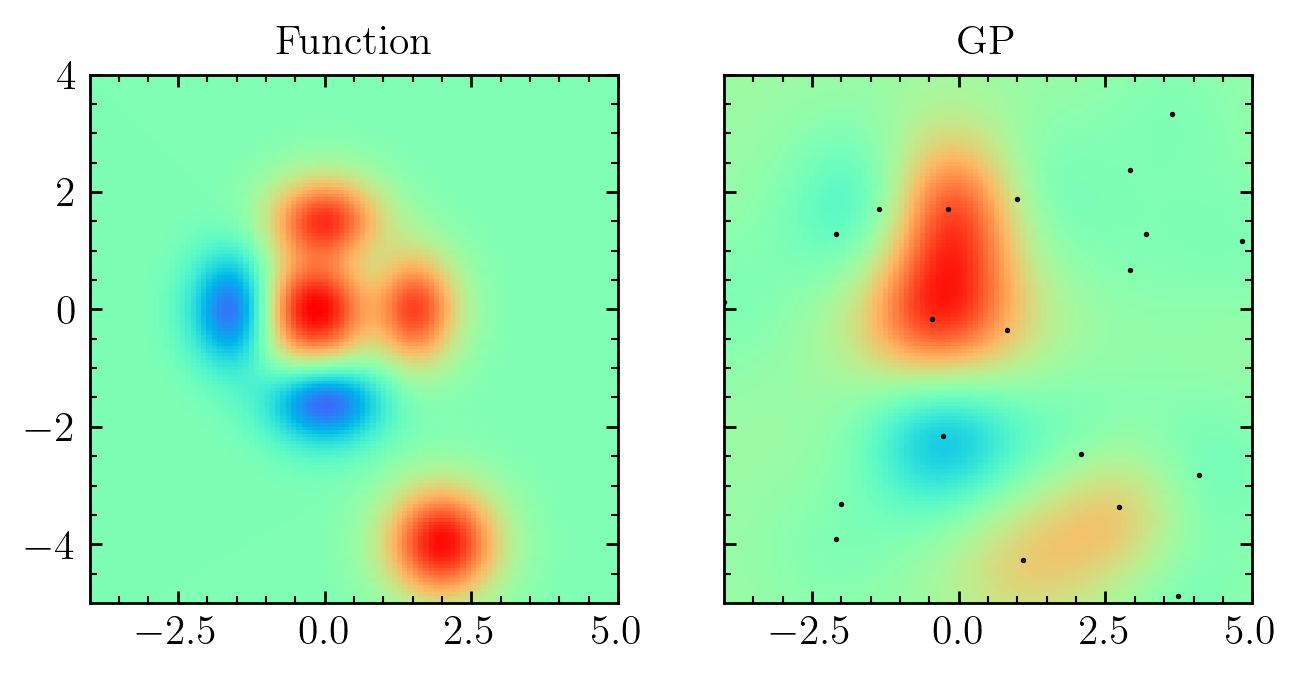

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)

ax = axs[0]
c = ax.imshow(
    z.T, cmap='rainbow', vmin=z_min, vmax=z_max,
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    interpolation ='nearest', origin ='lower'
)
adj.set_grids(ax, grid=False)
ax.set_title("Function")

ax = axs[1]
c = ax.imshow(
    mu, cmap='rainbow', vmin=z_min, vmax=z_max,
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    interpolation ='nearest', origin ='lower'
)
adj.set_grids(ax, grid=False)
ax.scatter(train_x[:, 0], train_x[:, 1], s=0.3, color="black")
# ax.scatter(X_original[:, 0], X_original[:, 1], s=0.3, color="blue")
ax.set_title("GP")

plt.show()

In [133]:
torch.manual_seed(123)

NLOOP = 100

for ii in tqdm(range(NLOOP)):
    candidate = bo.ask(
        model=model,
        bounds=[(-4, 5), (-5, 4)],
        acquisition_function="UCB", # acquisition_function="MaxVar",
        acquisition_function_kwargs={"beta": 0.1},
        optimize_acqf_kwargs={
            "q": 1,
            "num_restarts": 5,
            "raw_samples": 20,
        }
    )
    model = gp.tell(model=model, new_x=candidate, new_y=truth(candidate).reshape(1, 1))

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


In [134]:
new_x, new_y = gp.get_training_data(model=model)

In [135]:
loss = gp.train_gp_hyperparameters(model=model, train_x=new_x, train_y=new_y, training_iter=1000)

0/1000
	 Loss        = -2.410
	 Lengthscale = 0.966
	 Noise       = 0.000
200/1000
	 Loss        = -2.880
	 Lengthscale = 0.688
	 Noise       = 0.000
400/1000
	 Loss        = -2.882
	 Lengthscale = 0.688
	 Noise       = 0.000
600/1000
	 Loss        = -2.882
	 Lengthscale = 0.688
	 Noise       = 0.000
800/1000
	 Loss        = -2.883
	 Lengthscale = 0.688
	 Noise       = 0.000
1000/1000
	 Loss        = -2.883
	 Lengthscale = 0.688
	 Noise       = 0.000


In [136]:
pred = gp.infer(model=model, grid=grid)

In [137]:
mu = pred["mean"].reshape(M, N)

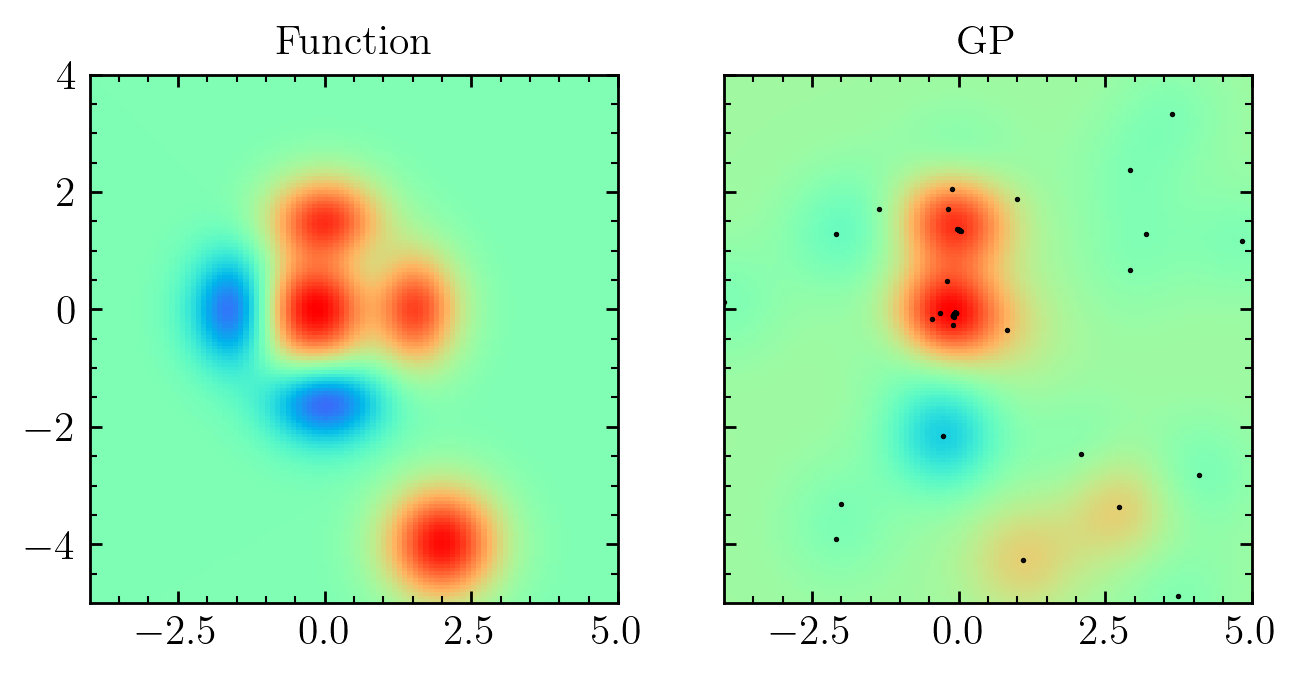

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)

ax = axs[0]
c = ax.imshow(
    z.T, cmap='rainbow', vmin=z_min, vmax=z_max,
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    interpolation ='nearest', origin ='lower'
)
adj.set_grids(ax, grid=False)
ax.set_title("Function")

ax = axs[1]
c = ax.imshow(
    mu, cmap='rainbow', vmin=z_min, vmax=z_max,
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    interpolation ='nearest', origin ='lower'
)
adj.set_grids(ax, grid=False)
ax.scatter(new_x[:, 0], new_x[:, 1], s=0.3, color="black")
# ax.scatter(X_original[:, 0], X_original[:, 1], s=0.3, color="blue")
ax.set_title("GP")

plt.show()